In [1]:
import os
#os.environ["PATH"] = "=/usr/local/cuda-12.2/bin:$PATH"
#os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-12.2/lib64:$LD_LIBRARY_PATH"
#os.environ["CUDA_HOME"] = "/usr/local/cuda-12.2"
os.environ["TF_USE_LEGACY_KERAS"] = "0"

import tensorflow as tf

from tensorflow.keras import layers, models, activations
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import hls4ml
from tqdm import tqdm
tf.__version__

2024-06-13 09:42:46.252575: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 09:42:46.525979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 09:42:46.526067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 09:42:46.574522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 09:42:46.681230: I tensorflow/core/platform/cpu_feature_guar

/home/rikpi/.local/lib/python3.11/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


'2.15.1'

In [2]:
#Set sample number
sample_num = 300

dataset_dict={300:'./dataset.npy', 500:'./dataset_500.npy', 800:'./dataset_800.npy', 1000:'./dataset_1000.npy'}


# Load the data
with open (dataset_dict[sample_num],'rb') as f:
  X_train = np.load(f,allow_pickle=True)
  Y_train = np.load(f,allow_pickle=True)
  X_val = np.load(f,allow_pickle=True)
  Y_val = np.load(f,allow_pickle=True)
  X_test =np.load(f,allow_pickle=True)
  Y_test =np.load(f,allow_pickle=True)

num_classes = len(np.unique(Y_train))
y_train_onehot = tf.keras.utils.to_categorical(Y_train, num_classes=num_classes)
y_val_onehot = tf.keras.utils.to_categorical(Y_val, num_classes=num_classes)
y_test_onehot = tf.keras.utils.to_categorical(Y_test, num_classes=num_classes)

In [3]:
from fxpmath import Fxp


X_test_reduced = X_test[:500]
X_test_reduced_fxp = Fxp(X_test_reduced, signed=True, n_word=24, n_int=7)
#print(X_test_reduced_fxp)
#X_test_reduced_17 = 
Y_test_reduced = y_test_onehot[:500]
Y_test_reduced_fxp = Fxp(Y_test_reduced, signed=True, n_word=24, n_int=7)

# Save data for csim/cosim
np.save('X_test.npy', X_test_reduced_fxp)
np.save('Y_test.npy', Y_test_reduced_fxp)

fxp-s16/15(0.0)

In [86]:
model_loaded = tf.keras.models.load_model('1DCNN_Moha_class_flatten.h5')

import hls4ml
import plotting

# First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model_loaded, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<20,7>'
hls_config['Model']['ReuseFactor'] = 4
hls_config['Model']['Strategy'] = 'Latency'

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource'
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation
# so we use the latency strategy and reuse factor of 1 for all layers.

precisions = {'batch_normalization_181' : 'ap_fixed<8,5>',
              'batch_normalization_182' : 'ap_fixed<4,2>',
              'conv1d_175' : 'ap_fixed<20,3>',
              'conv1d_175_input' : 'ap_fixed<20,7>',
              'conv1d_175_relu' : 'ap_fixed<20,3>',
              'conv1d_176' : 'ap_fixed<17,3>',
              'conv1d_176_relu' : 'ap_fixed<17,3>',
              'dense_199' : 'ap_fixed<16,2>',
              'dense_199_softmax' : 'ap_fixed<24,7>',
              'flatten_128' : 'ap_fixed<24,7>',
              'max_pooling1d_175' : 'ap_fixed<18,4>',
              'max_pooling1d_176' : 'ap_fixed<18,4>'}

dev_precisions = {'batch_normalization_181' : 'ap_fixed<8,5>',
              'batch_normalization_182' : 'ap_fixed<4,2>',
              'conv1d_175' : 'ap_fixed<20,3>',
              'conv1d_175_input' : 'ap_fixed<20,7>',
              'conv1d_175_relu' : 'ap_fixed<20,3>',
              'conv1d_176' : 'ap_fixed<17,3>',
              'conv1d_176_relu' : 'ap_fixed<17,3>',
              'dense_199' : 'ap_fixed<20,7>',
              'dense_199_softmax' : 'ap_fixed<20,7>',
              'flatten_128' : 'ap_fixed<24,7>',
              'max_pooling1d_175' : 'ap_fixed<18,4>',
              'max_pooling1d_176' : 'ap_fixed<18,4>'}

for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 4
    hls_config['LayerName'][Layer]['Precision'] = 'ap_fixed<20,7>' #dev_precisions[Layer]
# If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['dense_199']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado', part= 'XCZU7EV-FFVC1156-2-E')
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model_loaded
cfg['OutputDir'] = 'COSMIC_CNN_worker1/'
cfg['Board'] = 'zcu106'
cfg['Part'] = 'XCZU7EV-FFVC1156-2-E'
cfg['XilinxPart'] = 'XCZU7EV-FFVC1156-2-E'
cfg['Interface'] = 'axi_stream'
cfg['InputData'] = 'X_test.npy'
cfg['OutputPredictions'] = 'Y_test.npy'

hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: conv1d_175_input, layer type: InputLayer, input shapes: [[None, 300, 8]], output shape: [None, 300, 8]
Layer name: conv1d_175, layer type: Conv1D, input shapes: [[None, 300, 8]], output shape: [None, 300, 64]
Layer name: batch_normalization_181, layer type: BatchNormalization, input shapes: [[None, 300, 64]], output shape: [None, 300, 64]
Layer name: max_pooling1d_175, layer type: MaxPooling1D, input shapes: [[None, 300, 64]], output shape: [None, 150, 64]
Layer name: conv1d_176, layer type: Conv1D, input shapes: [[None, 150, 64]], output shape: [None, 150, 6]
Layer name: batch_normalization_182, layer type: BatchNormalization, input shapes: [[None, 150, 6]], output shape: [None, 150, 6]
Layer name: max_pooling1d_176, layer type: MaxPooling1D, input shapes: [[None, 150, 6]], output shape: [None, 75, 6]
Layer name: flatten_128, layer type: Reshape, input shapes: [[None, 75, 6]], output shape: [None, 450]
Layer name: dense_199, layer type: De

/home/rikpi/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


94/94 [==============================] - 0s 3ms/step
Accuracy Keras:  0.9116666666666666
Accuracy hls4ml: 0.9123333333333333


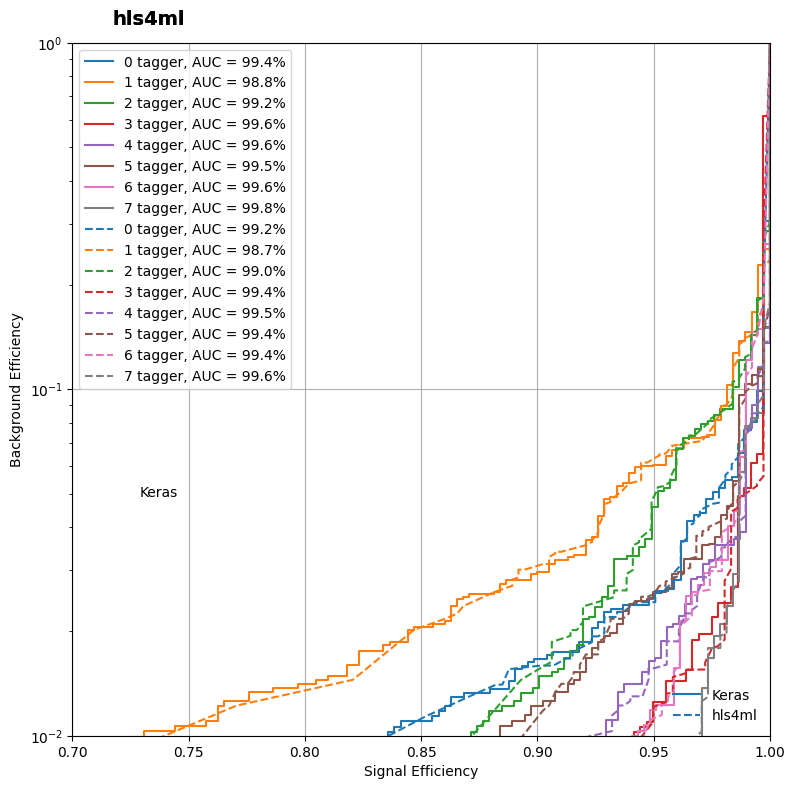

In [87]:
from fxpmath import Fxp


X_test_reduced = X_test[:3000]
X_test_reduced_fxp = Fxp(X_test_reduced, signed=True, n_word=20, n_int=3)
#print(X_test_reduced_fxp)
#X_test_reduced_16 = 
Y_test_reduced = y_test_onehot[:3000]
Y_test_reduced_fxp = Fxp(Y_test_reduced, signed=True, n_word=20, n_int=3)
n_classes = num_classes

y_predict = model_loaded.predict(np.float32(X_test_reduced))
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(X_test_reduced_fxp))

import plotting
from sklearn.metrics import accuracy_score


def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    accuracy_keras = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred, axis=1)))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred_hls4ml, axis=1)))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))

    fig, ax = plt.subplots(figsize=(9, 9))
    _ = plotting.makeRoc(Y, y_pred, labels=['%i' % nr for nr in range(n_classes)])
    plt.gca().set_prop_cycle(None)  # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, labels=['%i' % nr for nr in range(n_classes)], linestyle='--')

    from matplotlib.lines import Line2D

    lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend

    leg = Legend(ax, lines, labels=['Keras', 'hls4ml'], loc='lower right', frameon=False)
    ax.add_artist(leg)
    plt.figtext(0.2, 0.38, label, wrap=True, horizontalalignment='left', verticalalignment='center')
    plt.ylim(0.01, 1.0)
    plt.xlim(0.7, 1.0)


# Plot the pruned floating point model:
plotROC(Y_test_reduced, y_predict, y_predict_hls4ml, label="Keras")

Interpreting Sequential
Topology:
Layer name: conv1d_175_input, layer type: InputLayer, input shapes: [[None, 300, 8]], output shape: [None, 300, 8]
Layer name: conv1d_175, layer type: Conv1D, input shapes: [[None, 300, 8]], output shape: [None, 300, 64]
Layer name: batch_normalization_181, layer type: BatchNormalization, input shapes: [[None, 300, 64]], output shape: [None, 300, 64]
Layer name: max_pooling1d_175, layer type: MaxPooling1D, input shapes: [[None, 300, 64]], output shape: [None, 150, 64]
Layer name: conv1d_176, layer type: Conv1D, input shapes: [[None, 150, 64]], output shape: [None, 150, 6]
Layer name: batch_normalization_182, layer type: BatchNormalization, input shapes: [[None, 150, 6]], output shape: [None, 150, 6]
Layer name: max_pooling1d_176, layer type: MaxPooling1D, input shapes: [[None, 150, 6]], output shape: [None, 75, 6]
Layer name: flatten_128, layer type: Reshape, input shapes: [[None, 75, 6]], output shape: [None, 450]
Layer name: dense_199, layer type: De

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

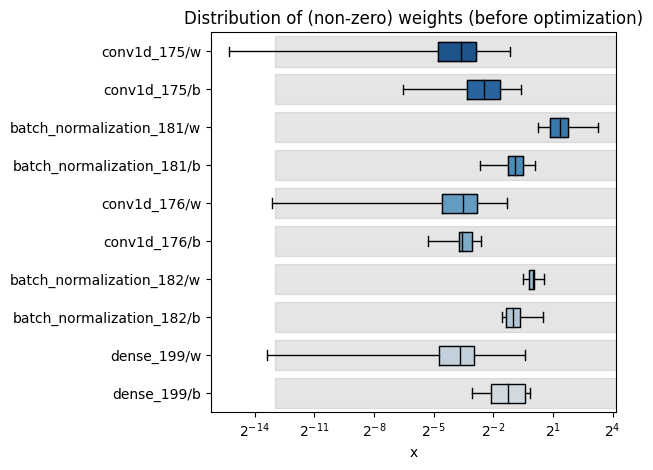

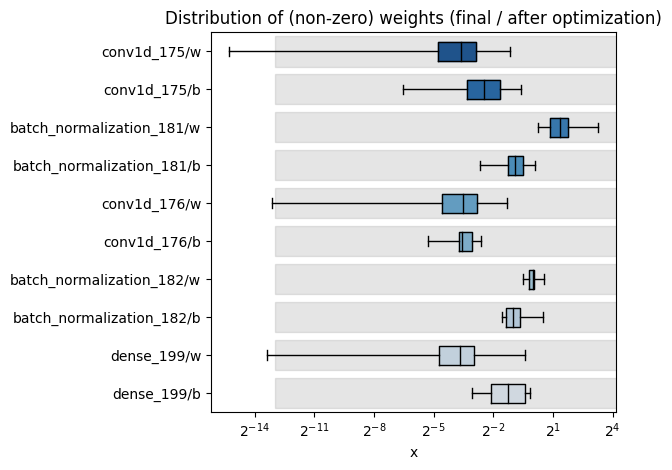

In [88]:
hls4ml.model.profiling.numerical(model=model_loaded, hls_model=hls_model)

In [91]:
import os

os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2022.1/bin:' + os.environ['PATH']
#os.environ['LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu:$LIBRARY_PATH' 

synth = True
if synth:
    hls_model.build(csim=True, synth=True, vsynth=True, export=True, cosim=False)
    #hls_model_q.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rikpi' on host 'b66286df32ab' (Linux_x86_64 version 5.15.146.1-microsoft-standard-WSL2) on Thu Jun 13 22:03:53 UTC 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.4 LTS
INFO: [HLS 200-10] In directory '/workspace/ws/COSMIC_CNN_worker1'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/workspace/ws/COSMIC_CNN_worker1/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to t